<h1><center>Laboratorio 9: Benchmark Estadístico con Reddit 🧮</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Pablo Badilla
- Auxiliar: Ignacio Meza D.
- Ayudante: Patricio Ortiz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Sebastian Avendaño
- Nombre de alumno 2: Felipe Urrutia


### **Link de repositorio de GitHub:** https://github.com/furrutiav/lab-mds-2022

# Temas a tratar

- Optimización de Código en Python.
- Utilización de librerías para medir el tiempo de ejecución de funciones.
- Métodos para optimizar el rendimiento de las funciones.

# Reglas:

- Fecha de entrega: 3/12/2021
- **Grupos de 2 personas**
- **Ausentes** deberán realizar la actividad solos. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.

# Objetivos principales del laboratorio

- Utilizar la API de Reddit a partir de la librería `praw` y visualizar cuales post son más probables que sean puntuados positivamente.
- Utilizar `cache_lru` para cachear resultados de funciones.
- Aplicar un atajo estadístico para obtener la mean posterior de datos.
- Medir el tiempo de ejecución como también el uso de memoria de la función anterior.
- Optimizar la función anterior a través de `numba`.

#Importamos librerias utiles 😸

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
%%capture
!pip install praw
!pip install line_profiler
!pip install numba

%load_ext autoreload
%autoreload 2

import sys
import praw
import time
import numpy as np
import pandas as pd
from numba import jit
import plotly.express as px
from functools import lru_cache
from IPython.core.display import Image

# 1. Recomendando Posts de Subreddit

<p align="center">
  <img src="https://preview.redd.it/3sxusxcjge791.png?auto=webp&s=88bc1f9a3c59eafda24b0e32dd87d7cf596d205d">
</p>

Unos intrépidos alumnos del curso, quienes frecuentemente participan en subreddits y foros de reviews, se preguntan lo siguiente: ¿Podremos confiar que un post es bueno, si este tiene solamente 1 o 3 votos positivos?. los compañeros, creen que esto claramente no representa una opinión general, ya que estamos mucho menos seguros acerca de la verdadera proporción de votos a favor de los comentarios con pocos datos. ¿Pero cómo podemos obtener una representación más creíble para este problema?.

Lo señalado forma parte de un problema estadísticos, donde a través del cálculo de la posterior se puede conocer que tan probable es que un post sea bueno. Para efectos de este laboratorio, no se exige un conocimiento previo para resolver este problema, simplemente se deberá aplicar las ecuaciones presentadas más adelante (De igual forma si quedan interesados sobre el tema se les invita a tomar el ramo [CC6104](https://github.com/dccuchile/CC6104)).

## 1.1 Obtención de Subrredits y Análisis [1 Punto]

Para estudiar que tan probable es que un post sea positivo se comenzará cargando datos reales del subreddit chile desde reddit (si usted desea puede cambiar el subreddit a uno de su gusto). Para esto le proponemos la utilización de la función que aparece mas abajo, la que presenta un usuario ya creado por el equipo docente. Dese un tiempo para entender que hace cada parte de la función, visualizando que se obtiene de estas.

Revisada la función, utilice un **perfilador** para monitorear el tiempo y memoria que les toma a cada liena de código para ser ejecutada. Señale cuales son los procesos que mas tiempo consumen en la ejecución del Código, comentando si es posible mejorar el desempeño de la función.

**TO-DO:**
- [ ] Estudiar la función propuesta por el equipo docente.
- [ ] Estudiar los tiempos de ejecución del código a través de un perfilador.
- [ ] Estudiar la memoria ocupada por el código a través de un perfilador.
- [ ] Comente los resultados. ¿Qué lineas ocupan más memoria o más/menos tiempo?¿Por qué?

In [5]:
#%%file bench_module.py
import praw
import numpy as np

def praw_reddit(nombre_subreddit="chile", n_hot=1000):
    reddit = praw.Reddit(
        client_id="-w2hyFINxZ8T3g",
        client_secret="zGPCI4s3g6Ic6AsRi7vIpP0NoxbFdw",
        password="ClasesMDS7202",
        user_agent="Clases",
        username="DocenciaDataScience",
        check_for_async=False,
    )
    subreddit = reddit.subreddit(nombre_subreddit)

    votes, post, url = {}, {}, {}
    top_submissions = list(subreddit.hot(limit=n_hot))
    for it, top_n in enumerate(range(50, len(top_submissions), 50)):
        top_n_submissions = top_submissions[:top_n]
        upvotes, downvotes, url[it], post[it] = [], [], [], []

        for submission in top_n_submissions:
            try:
                ratio = submission.upvote_ratio
                ups = int(
                    round((ratio * submission.score) / (2 * ratio - 1))
                    if ratio != 0.5
                    else round(submission.score / 2)
                )
                upvotes.append(ups)
                downvotes.append(ups - submission.score)
                post[it].append(submission.title)
                url[it].append(submission.url)
            except Exception as e:
                continue
        votes[it] = np.array([upvotes, downvotes]).T
    return votes, post, url

In [6]:
votes, post, url = praw_reddit()

### Estudiar la función propuesta por el equipo docente.

La funcion $\texttt{praw_reddit}$ recibe un subreddit (por defecto "chile") y un numero denotado por $\texttt{n_hot}$ (por defecto 1000). Retorna un resumen de los reslutados entregados por la API *praw* de los top-post mas "hot" en el subreddit establecido en el input. En particular, entre los votos (up/down votes), post (titulo del post) y url (una ruta a cada post). Internamente la funtion determina los votos segun dos parametros de cada post (o submission). Esto son: upvote_ratio y score. El primero corresponde a la proporcion de votos up del total de votos. Mientras que el segundo es la diferencia entre los votos up y los votos down. Para determinar los votos up, basta determinar (upvote_ratio * score) / (2 * upvote_ratio - 1). Luego, los votos down, se determinan con votos up - score. El output final de la funcion es un trio (votes, post, url), donde cada elemento del trio es una lista de listas. Donde cada sublista es una version truncada de la lista que le sigue. Esto ya que internamente la funcion realiza un ciclo for con pasos de tamaño 50, y almacena los datos de los primeros k hot-post, con k multiplo positivo de 50. A priori, consideramos que esta ultima observacion produce que el algoritmo no sea optimo, al realizar iteraciones innecesarias.

### Estudiar los tiempos de ejecución del código a través de un perfilador.

In [11]:
!pip install line_profiler
%load_ext line_profiler

In [22]:
%lprun -f praw_reddit praw_reddit()

<img src="perfilador.jpg" width=800 />

**Respuesta:**

Del perfilador se concluye que la mayoria del tiempo (99.7% del tiempo de ejecucion de la funcion) es consumida por la linea 13. Esto corresponde al llamado subreddit.hot(limit=n_hot) con el objeto "subreddit" y metodo "hot". Este resultado es esperable dado que en la linea 2 se inicializa el wrapper (de la libreria praw) con las credenciales, lo que no consume tiempo. Pero, en la linea 13 se realiza la primera peticion a la API. Ademas, este tiempo puede ser grande ya que el parametro 𝚗⎯𝚑𝚘𝚝 tambien lo es. Ahora bien, si omitimos el tiempo que consume la linea 13, el otro gran porcentaje de tiempo utilizado se debe al ciclo for que comienza en la linea 18.

### Estudiar la memoria ocupada por el código a través de un perfilador.

In [29]:
!pip install memory_profiler
%load_ext memory_profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=e572902a7ae98b599b7668791c1c83038454046fb925865f03451fef6de3fb15
  Stored in directory: c:\users\felip\appdata\local\pip\cache\wheels\01\ca\8b\b518dd2aef69635ad6fcab87069c9c52f355a2e9c5d4c02da9
Successfully built memory-profiler


In [40]:
from bench_module import praw_reddit
%mprun -f praw_reddit praw_reddit()

<img src="perfilador_mem.jpg" width=800 />

**Respuesta:**

Del perfilador de memoria se concluye que la mayoria de la memoria reportada (13.9 MiB) es ocupada por la linea 13. Por misma razon que antes, esto corresponde al llamado de subreddit.hot(limit=n_hot), dado que recibe los resultados de la peticion realizada a la API. A diferencia de antes, el ciclo for no tiene una contribucion significativa en la memoria ocupada por la funcion.

### Comente los resultados. ¿Qué lineas ocupan más memoria o más/menos tiempo?¿Por qué?

**Respuesta:**

En resumen, tanto para el consumo de memoria como de tiempo es debido a la linea 13. Que corresponde a la peticion relizada a la API (tiempo) que devuelve los post mas "hot" (espacio). Tambien se menciono anteriormente que el ciclo for de la linea 18, consume otra gran parte del tiempo de ejecucion de la funcion. Lo utlimo, puede deberse a la gran cantidad de iteraciones que realizan las linea de codigo dentro del ciclo for (ver columna Hits en el reporte del perfilador de tiempo, o Ocurrences en el reporte del perfilador de memoria). Tambien notamos que la funcion tiene un try/except como medida de seguridad. Sin embargo, durante la ejecucion nunca se entra a la excepción.

## 1.2 LRU y Análisis de Tiempo con Cache [1 Punto]

Respondan las siguientes preguntas:

1.	¿Qué es la memoria cache y a que se refiere las siglas LRU?
2.	¿Cuáles son los costos que tiene la aplicación de técnicas de Caching?
3. ¿Cuál es la consecuencía de ocupar caching en la función anterior?.

Respondidas las preguntas, se le solicita que aplique alguna técnica de caching para mejorar el desempeño de la función `praw_reddit`. Para esto compare solo el tiempo de ejecución del algoritmo con y sin caching, señalando el tiempo total de ejecución y el tiempo promedio que le toma ejecutar cada loop a la función. Con lo anterior, ¿es posible visualizar mejoras en este caso?.


**TO-DO:**
- [ ] Responder las preguntas.
- [ ] Mejorar el código con cache.
- [ ] Explicar las consecuencias de usar lru_cache sobre praw_reddit

### Responder las preguntas

**Respuestas Teóricas:**

1.a) [Memoria cache] La memoria cache es un tipo de memoria que nos permite almacenar informacion (datos). Este tipo de memoria tiene el unico fin de acceder rapidamente en consultas posteriores. Dichas consultas (o accesos de memoria), tienen la caracteristica de ser repetitivas. Un ejemplo practico de su uso es en funciones recursivas, las cuales suelen ser optimizadas con programacion dinamica. 

1.b) [LRU] Son las siglas en ingles de "Menos usado recientemente" (Least recently used). Este es un algoritmo basico para gestionar la memoria cache. La memoria de este tipo suele tener un largo pequeño, equivalente al numero de elementos almacenados. Si la memoria cache esta lleba, y se desea añadir un elemenot en la memoria, tal como lo dice el nombre del algoritmo, se descarta el elemento menos usado recientemente en la memoria. Para esto, el algoritmo debe de mantener contadores para identificar los elementos menos usados (o consultados).

2.- Este tipo de algoritmos se utiliza para reducir el tiempo de ejecucion de una funcion (o codigo con inputs y output deterministico). La forma de lograr esto, es intercambiando tiempo por espacio. En este caso, el espacio es sinonimo de memoria. Tal como se motivo en la pregunta anterior, dicha memoria es de tipo cache. En efecto, los costos de utilizar técnicas de Caching son en memoria (o espacio).

3.- La consecuencia de ocupar caching en la función anterior es que al realizar otra vez el mismo llamado de esta funcion, se recibira el mismo output que quedo almacenado en memoria cache. Pese a que esto puede ser una buena idea, ya que el tiempo de ejecucion es considerable, utilizar este metodo no es del todo apropiado. Esto se debe a que la respuesta de la funcion varía con el tiempo. Como se reciben los hot-post, en un par se semanas hasta incluso dias, los post mas hot debiesen de ser otros.

### Mejorar el código con cache.

In [23]:
@lru_cache
def praw_reddit(nombre_subreddit="chile", n_hot=1000):
    reddit = praw.Reddit(
        client_id="-w2hyFINxZ8T3g",
        client_secret="zGPCI4s3g6Ic6AsRi7vIpP0NoxbFdw",
        password="ClasesMDS7202",
        user_agent="Clases",
        username="DocenciaDataScience",
        check_for_async=False,
    )
    subreddit = reddit.subreddit(nombre_subreddit)

    votes, post, url = {}, {}, {}
    top_submissions = list(subreddit.hot(limit=n_hot))
    for it, top_n in enumerate(range(50, len(top_submissions), 50)):
        top_n_submissions = top_submissions[:top_n]
        upvotes, downvotes, url[it], post[it] = [], [], [], []

        for submission in top_n_submissions:
            try:
                ratio = submission.upvote_ratio
                ups = int(
                    round((ratio * submission.score) / (2 * ratio - 1))
                    if ratio != 0.5
                    else round(submission.score / 2)
                )
                upvotes.append(ups)
                downvotes.append(ups - submission.score)
                post[it].append(submission.title)
                url[it].append(submission.url)
            except Exception as e:
                continue
        votes[it] = np.array([upvotes, downvotes]).T
    return votes, post, url

### Explicar las consecuencias de usar lru_cache sobre praw_reddit

Sin Caché:

In [22]:
%%timeit
votes1, post1, url1 = praw_reddit()

18.3 s ± 546 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Con caché - Primer llamado:

In [24]:
%%timeit
votes3, post3, url3 = praw_reddit()

257 ns ± 266 ns per loop (mean ± std. dev. of 7 runs, 1 loop each)


Con caché - Segundo llamado:

In [25]:
%%timeit
votes4, post4, url4 = praw_reddit()

59 ns ± 0.536 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


Comentarios: Se puede observar que la ejecución normal se demora notablemente, hasta 10 órdenes de magnitud más que la ejecución con caché. Luego, al ejecutar nuevamente la función con caché, se puede ver ahora la ejecución tarda 5 veces menos. 

La diferencia entre la ejecución con y sin caché es principalmente que la ejecución con caché está guardando el resultado y no ejecuta los pasos intermedios al volver a llamarse. También existe diferencia entre la primera y segunda ejecución con caché, lo que puede deberse a ...

La principal consecuencia de usar caching en este ya fue expuesta anteriormente, y es que al ejecutarse la función no está pidiendo información nueva al servidor, lo que estanca los resultados, pudiendo ser contraproducente con una función que pretende evaluar la actualidad de un tema en reddit.

## 1.3 Obtención de Mean Posterior y Standard Error [1 Punto]

Una forma de obtener la mean posterior y el Standard Error de los datos de reddit es aplicando un atajo de inferencia estadística. Este atajo se define de la siguiente forma:

Sea **u** los votos positivos y **d** los votos negativos del subreddit, tendremos que:

$$a = 1+u$$

$$b = 1+d$$

$$\sigma= 1.65\sqrt(\dfrac{ab}{(a + b)^2(a + b + 1)})$$

$$\mu = \dfrac{a}{a+b}$$

Donde $\mu$ es la mean posterior y $\sigma$ el standard error.

Con lo anterior, genere dos funciones que tengan como salida $\mu$ y $\sigma$ de acuerdo a las ecuaciones señaladas. La primera función, deberá ser construida sin el uso de numpy, aplicando for y aplicando comandos nativos de Python. Por otro lado, deberá generar una segunda función con el uso exclusivo de numpy. **OJO** que las funciones deben tener como entrada solo un elemento del diccionario votes (por ejemplo `votes[1]`), por lo que estas no deben tener como entrada el conjunto completo de datos.

In [37]:
def mu_sgm_python(botes):
    out = []
    for (u, d) in botes:
        a, b = 1+u, 1+d
        sgm = 1.65 * ( ( a*b / ( (a+b)**2 * (a+b+1))) ** 0.5 )
        mu = a / (a+b)
        out.append([mu, sgm])
    return out

In [41]:
%%timeit
mu_sgm_python(votes[9])

982 µs ± 4.99 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [39]:
def mu_sgm_numpy(botes):
    a_b = botes+np.ones(1)
    a, b = a_b[:,0], a_b[:,1]
    sgm = 1.65 * np.sqrt( a*b / ((a+b)**2*(a+b+1)))
    mu = a/(a+b)
    out = np.column_stack((mu,sgm))
    return out

In [42]:
%%timeit
mu_sgm_numpy(votes[9])

21 µs ± 137 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## 1.4 Comparación de Rendimiento [2 Puntos]

Ahora, aplique el compilador **Numba** sobre las funciones 1.3 y compare el tiempo de ejecución con los obtenidos sin el compilador. 

Para esto genere un gráfico de linea utilizando plotly, en donde se pueda observar el tiempo que toma ejecutar cada función (el eje y) diferentes cantidades de datos (ejemplo, en el eje x considerar 100, 200, 300, ..., 1000 datos) sobre cada función implementada (series `Python`, `Numpy`, `Python-JIT`, `Numpy-JIT`). ¿Es posible observar diferencias? ¿A qué se debe esto?.

**Nota:** Ejecuten las funciones compiladas con algún ejemplo antes de graficar. De lo contrario, les indicará el tiempo de compilación, cosa que no queremos medir

**Nota 2**: En el caso que su computador sea muy rápido, se recomienda graficar el eje y (tiempo) como logaritmo usando `log_y=True`.


In [46]:
@jit(nopython=True)
def mu_sgm_python_jit(botes):
    out = []
    for (u, d) in botes:
        a, b = 1+u, 1+d
        sgm = 1.65 * ( ( a*b / ( (a+b)**2 * (a+b+1))) ** 0.5 )
        mu = a / (a+b)
        out.append([mu, sgm])
    return out

In [52]:
mu_sgm_python_jit(votes[9])

[[0.5, 0.4763139720814412],
 [0.8494983277591973, 0.01968782329426981],
 [0.9030303030303031, 0.03789649823286122],
 [0.9484536082474226, 0.036853444720721815],
 [0.7727272727272727, 0.06563103254126383],
 [0.9305555555555556, 0.04909219167918721],
 [0.9714285714285714, 0.032623171862033166],
 [0.8577777777777778, 0.03833547512292874],
 [0.8309859154929577, 0.0728745651213009],
 [0.9565217391304348, 0.02854039953512982],
 [0.9703703703703703, 0.023990890306941102],
 [0.7936507936507936, 0.05925134491344022],
 [0.8632478632478633, 0.05218885359396381],
 [0.9090909090909091, 0.08134892168199606],
 [0.963855421686747, 0.03360251856149524],
 [0.7529411764705882, 0.07673887484639132],
 [0.8181818181818182, 0.033356219249749554],
 [0.9139784946236559, 0.04771902100855602],
 [0.95, 0.039956573649122834],
 [0.7361111111111112, 0.06039238513250108],
 [0.95, 0.0784731528249357],
 [0.9491525423728814, 0.046796238772244904],
 [0.8260869565217391, 0.12766071823080916],
 [0.7916666666666666, 0.13401

In [53]:
%%timeit
mu_sgm_python_jit(votes[9])

103 µs ± 1.03 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [47]:
@jit(nopython=True)
def mu_sgm_numpy_jit(botes):
    a_b = botes+np.ones(1)
    a, b = a_b[:,0], a_b[:,1]
    sgm = 1.65 * np.sqrt( a*b / ((a+b)**2*(a+b+1)))
    mu = a/(a+b)
    out = np.column_stack((mu,sgm))
    return out

In [54]:
mu_sgm_numpy_jit(votes[9])

array([[0.5       , 0.47631397],
       [0.84949833, 0.01968782],
       [0.9030303 , 0.0378965 ],
       [0.94845361, 0.03685344],
       [0.77272727, 0.06563103],
       [0.93055556, 0.04909219],
       [0.97142857, 0.03262317],
       [0.85777778, 0.03833548],
       [0.83098592, 0.07287457],
       [0.95652174, 0.0285404 ],
       [0.97037037, 0.02399089],
       [0.79365079, 0.05925134],
       [0.86324786, 0.05218885],
       [0.90909091, 0.08134892],
       [0.96385542, 0.03360252],
       [0.75294118, 0.07673887],
       [0.81818182, 0.03335622],
       [0.91397849, 0.04771902],
       [0.95      , 0.03995657],
       [0.73611111, 0.06039239],
       [0.95      , 0.07847315],
       [0.94915254, 0.04679624],
       [0.82608696, 0.12766072],
       [0.79166667, 0.13401842],
       [0.75806452, 0.08902593],
       [0.77777778, 0.12963624],
       [0.95819398, 0.01349325],
       [0.93846154, 0.01856877],
       [0.85714286, 0.08804958],
       [0.99604743, 0.00649601],
       [0.

In [55]:
%%timeit
mu_sgm_numpy_jit(votes[9])

5.49 µs ± 57.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Calentar funciones:

In [56]:
_ = mu_sgm_python_jit(votes[9]), mu_sgm_numpy_jit(votes[9])

In [57]:
%%timeit
mu_sgm_python_jit(votes[9])

101 µs ± 567 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [58]:
%%timeit
mu_sgm_numpy_jit(votes[9])

5.48 µs ± 43.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [65]:
if __name__ == '__main__':
    import timeit
    data = []
    dic_fun = {
        "Python": "mu_sgm_python",
        "Numpy": "mu_sgm_numpy",
        "Python-JIT": "mu_sgm_python_jit",
        "Numpy-JIT": "mu_sgm_numpy_jit"
    }
    for k, v in dic_fun.items():
        for i in range(10):
            t = timeit.Timer(f"{v}(votes[{i}])", f"from __main__ import {v}, votes")
            t = t.timeit(number=1000)
            o = {"Función": k, "N° de datos": len(votes[i]), "Tiempo (ms)": t}
            data.append(o)

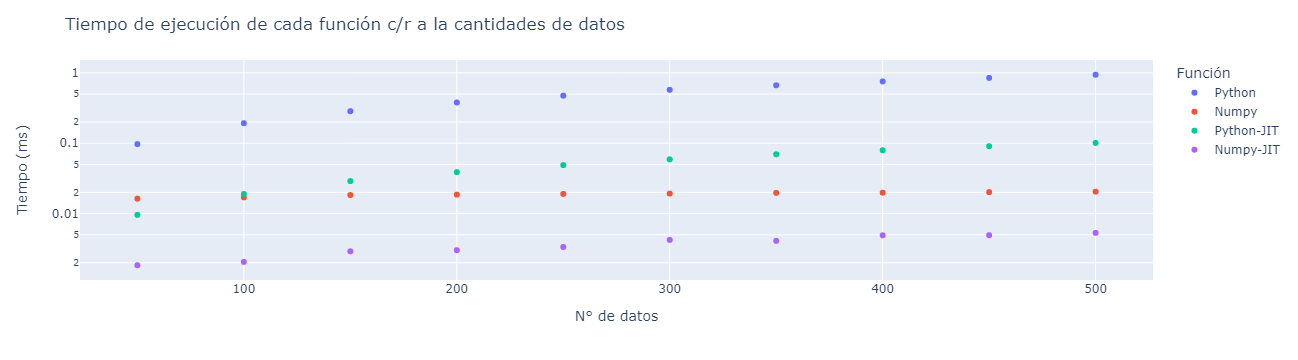

In [66]:
df_tabla = pd.DataFrame(data)
fig = px.scatter(df_tabla, x="N° de datos", y="Tiempo (ms)", color="Función",log_y=True)
fig.update_layout(
    title="Tiempo de ejecución de cada función c/r a la cantidades de datos"
)
fig.show()#renderer="notebook")

**Comentarios:**

En primer lugar, les ejecuciones de Python, compiladas o no, se tardan en general más que las de Numpy. Esto se debe al ventajoso manejo de la memoria de Numpy, haciéndolo más eficiente que Python. Luego, la diferencia entre las compiladas y las no compiladas es notoria, dado que las funciones que fueron compiladas se demoran aproximadamente 1 orden de magnitud menos, ya sea Python o Numpy. Esto último se debe a que la compilación previa optimiza el código, al comunicarse de forma más eficiente con el procesador.

En Python, la diferencia de tiempos entre ejecución compilada y no compilada se mantiene para todas las cantidades de datos, aunque se incremente el tiempo de ejecución. Por otro lado, se puede observar que las diferencias de los tiempos compilado y no compilado se acrecenta hacia el lado derecho del gráfico ( PONER POR QUE?)

## 1.5 Plot de Resultados de Análisis de Votos [1 Punto]

Llego la hora de visualizar los resultados obtenidos, para esto solo ejecute las siguientes celdas y observe lo que sucede :3. ¿Qué logra observar de los resultados?, ¿La solución resulta trivial?

En esta sección esperamos que solo comenten con lo que logran visualizar de los dataframes.

In [221]:
def intervals_numpy(x, y):
    o = mu_sgm_numpy_jit(np.column_stack((x,y)))
    return o[:,0], o[:,1] 

In [148]:
def mu_sgm_python(botes):
    out = []
    for (u, d) in botes:
        a, b = 1+u, 1+d
        sgm = 1.65 * ( ( a*b / ( (a+b)**2 * (a+b+1))) ** 0.5 )
        mu = a / (a+b)
        out.append([mu, sgm])
    return out

In [149]:
def mu_sgm_numpy(botes):
    a_b = botes+np.ones(1)
    a, b = a_b[:,0], a_b[:,1]
    sgm = 1.65 * np.sqrt( a*b / ((a+b)**2*(a+b+1)))
    mu = a/(a+b)
    out = np.column_stack((mu,sgm))
    return out

In [150]:
%%timeit
mu_sgm_python(votes[9])

1.03 ms ± 3.61 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [151]:
%%timeit
mu_sgm_numpy(votes[9])

18.2 µs ± 420 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [228]:
votos = votes[len(votes) - 1]
posteo = post[len(post) - 1]
print("lower bounds aproximados:")
posterior_mean, std_err = intervals_numpy(votos[:, 0], votos[:, 1])
lb = posterior_mean - std_err
print("\nTop 20 post ordenador por el limite inferior:\n")
order = np.argsort(-lb)
vote_post = {
    'Votos (+)': votos[order[:20], 0],
    'Votos (-)': votos[order[:20], 1],
    'Post': np.array(posteo)[order[:20]],
    'url': np.array(url[len(url) - 1])[order[:20]]
}
df = pd.DataFrame(data=vote_post)
ordered_post = df.Post
df

lower bounds aproximados:

Top 20 post ordenador por el limite inferior:



,Votos (+),Votos (-),Post,url
0,233,0,Gobierno queda fuera de querella por asesinato...,https://www.eldinamo.cl/pais/Gobierno-queda-fu...
1,226,0,Empresa le paga por error sueldo de $ 165 mill...,https://www.t13.cl/noticia/diario-financiero/n...
2,213,0,Macabro hallazgo en San José de Maipo: perro l...,https://www.biobiochile.cl/noticias/nacional/r...
3,1334,13,"En el Sodimac de Coyhaique, el pasillo de comi...",https://i.redd.it/iynxtajwdn491.png
4,1032,10,fonasa,https://i.redd.it/az7ge5c891691.png
5,700,7,ahora no po',https://i.redd.it/83odxdkaq9791.png
6,694,7,hoy en fotos que envejecieron mal....,https://i.redd.it/t09uq869jg591.jpg
7,764,8,Bolos,https://i.redd.it/8tx19xd0k2691.jpg
8,522,5,la situación de los pudúes en Chiloé es crític...,https://www.reddit.com/gallery/vhblmb
9,652,7,Cachen las imágenes lindas que compartieron en...,https://www.facebook.com/CONAF/posts/396515762...


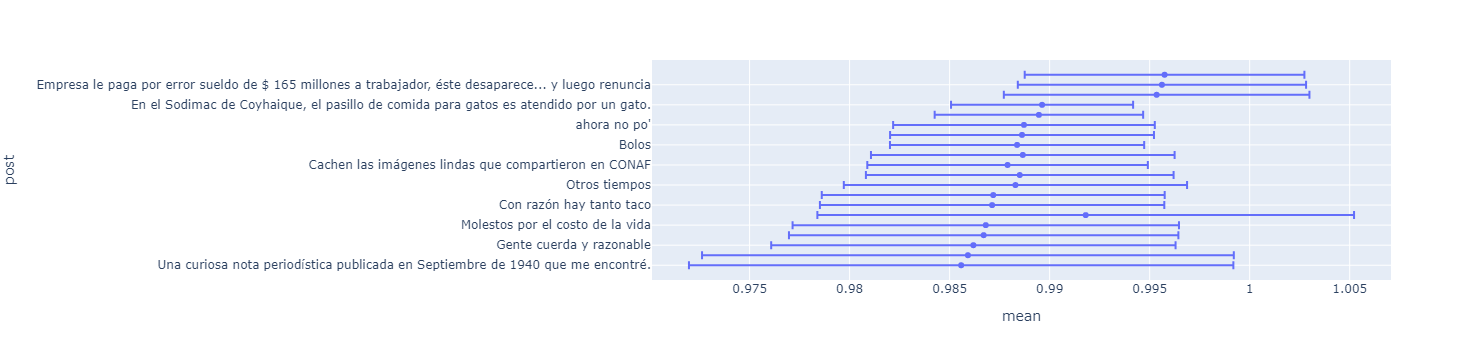

In [230]:
r_order = order[::-1][-20:]
data_dic = {
    'mean': posterior_mean[r_order],
    'std_err': std_err[r_order],
    'post': ordered_post[::-1]
}
df = pd.DataFrame(data=data_dic)
fig = px.scatter(df, x="mean", y="post", error_x="std_err")
fig.show()

###  ¿Qué logra observar de los resultados?, ¿La solución resulta trivial? En esta sección esperamos que solo comenten con lo que logran visualizar de los dataframes.

**Respuesta:**

`Escriba su respuesta aquí`

<p align="center">
  <img src="https://media1.tenor.com/images/fb5bf7cc5a4acb91b4177672886a88ba/tenor.gif?itemid=5591338">
</p>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>